# Employee Retention

## Goal
Employee turn-over is a very costly problem for companies. The cost of replacing an employee
if often larger than 100K USD, taking into account the time spent to interview and find a
replacement, placement fees, sign-on bonuses and the loss of productivity for several months.<br><br>
It is only natural then that data science has started being applied to this area. Understanding
why and when employees are most likely to leave can lead to actions to improve employee
retention as well as planning new hiring in advance. This application of DS is sometimes called
people analytics or people data science (if you see a job title: people data scientist, this is your
job).<br><br>
In this challenge, you have a data set with info about the employees and have to predict when
employees are going to quit by understanding the main drivers of employee churn.

## Challenge Description
We got employee data from a few companies. We have data about all employees who joined
from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the
company as of 2015/12/13 or they have quit. Beside that, we have general info about the
employee, such as avg salary during her tenure, dept, and yrs of experience.<br><br>
As said above, the goal is to predict employee retention and understand its main drivers.
Specifically, you should:<br>
- Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate
employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
You should create a table with 3 columns: day, employee_headcount, company_id.
- What are the main factors that drive employee churn? Do they make sense? Explain your
findings.
- If you could add to this data set just one variable that could help explain employee churn,
what would that be?


## Load data

In [8]:
import pandas as pd
data = pd.read_csv("data/employee_retention_data.csv", index_col = 'employee_id')
data.head()

,company_id,dept,seniority,salary,join_date,quit_date
employee_id,,,,,,
13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
927315.0,4,marketing,14,101000.0,2014-10-13,NaN
662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


## Analyze by descrbing data 
- total sample size are 24702
- from data info, we can see that, about 55% employee in the dataset quited the job. 
- when hired, the average year of experience of the employee is about 14
- average year of salary is about 138k/year

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [12]:
data.describe()

,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000
mean,3.426969,14.127803,138183.345478
std,2.700011,8.089520,76058.184573
min,1.000000,1.000000,17000.000000
25%,1.000000,7.000000,79000.000000
50%,2.000000,14.000000,123000.000000
75%,5.000000,21.000000,187000.000000
max,12.000000,99.000000,408000.000000


seniority is number of yrs of work experience when hired, so it is unusual to have a max of 99. We should take a deeper look into that data
- from value counts when can see that, there are two outliers, with 98&99 years of experience, so we remove these two records from datasets

In [18]:
data['seniority'].value_counts().sort_values()
data = data[data['seniority']<30]
data.describe()

,company_id,seniority,salary
count,24700.000000,24700.000000,24700.000000
mean,3.426802,14.120972,138176.275304
std,2.699752,8.054137,76056.331953
min,1.000000,1.000000,17000.000000
25%,1.000000,7.000000,79000.000000
50%,2.000000,14.000000,123000.000000
75%,5.000000,21.000000,187000.000000
max,12.000000,29.000000,408000.000000


### Categorical data overview
- employees are from 6 departments, most of which are from customer service dept (37%)

In [23]:
print(data.describe(include=['O']))

                    dept   join_date   quit_date
count              24700       24700       13508
unique                 6         995         664
top     customer_service  2012-01-03  2015-05-08
freq                9180         105         111


In [48]:
print(data['dept'].value_counts())
print(data['company_id'].value_counts())

customer_service    9180
engineer            4612
data_science        3190
sales               3172
marketing           3166
design              1380
Name: dept, dtype: int64
1     8485
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     864
12      24
11      16
Name: company_id, dtype: int64


## Analyze by pivoting features
- before pivoting features, creating a new columns first, left(False: has left the company/True: still working in the company)

In [28]:

data.loc[data['quit_date'].isnull(), 'retention'] = True
data.loc[data['quit_date'].notnull(), 'retention'] = False
print(data['retention'].value_counts())


False    13508
True     11192
Name: retention, dtype: int64


### check whether retention rate is vary by company or department
- company 11 has extremely low retention rate with about 25%, comparing the average of 45%, with a highest 50% of company 12
- retention rate by department do no vary much
- by further looking into data, we found that company 11 and 12 has rather small sample size, which may add noise to the analysis, so droping those data records

In [29]:
print(data.columns)
categories = ['company_id', 'dept']
for cate in categories:
    print (data[[cate, 'retention']].groupby([cate], as_index=False).mean().sort_values(by='retention', ascending=False))
    print ("_"*40)

Index(['company_id', 'dept', 'seniority', 'salary', 'join_date', 'quit_date',
       'left', 'retention'],
      dtype='object')
    company_id  retention
11          12   0.500000
1            2   0.477499
0            1   0.455510
8            9   0.449532
5            6   0.448490
7            8   0.446991
9           10   0.445602
2            3   0.443070
3            4   0.440834
4            5   0.439886
6            7   0.434641
10          11   0.250000
________________________________________
               dept  retention
3          engineer   0.488075
1      data_science   0.472727
0  customer_service   0.445098
4         marketing   0.437145
2            design   0.436232
5             sales   0.429067
________________________________________


In [49]:
print(data['company_id'].value_counts())

1     8485
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     864
12      24
11      16
Name: company_id, dtype: int64


In [55]:
# data = data.drop(['left'], axis=1)
data = data[data['company_id']<11]
print(data.info())
print(data.describe())
print(data['retention'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 24660 entries, 13021.0 to 777612.0
Data columns (total 8 columns):
company_id    24660 non-null int64
dept          24660 non-null object
seniority     24660 non-null int64
salary        24660 non-null float64
join_date     24660 non-null object
quit_date     13484 non-null object
retention     24660 non-null bool
diff_years    24660 non-null float64
dtypes: bool(1), float64(2), int64(2), object(3)
memory usage: 1.5+ MB
None
         company_id     seniority         salary    diff_years
count  24660.000000  24660.000000   24660.000000  24660.000000
mean       3.413544     14.123682  138258.272506      2.454170
std        2.681708      8.053616   76052.618716      1.408467
min        1.000000      1.000000   17000.000000      0.008214
25%        1.000000      7.000000   79000.000000      1.237534
50%        2.000000     14.000000  123000.000000      2.469592
75%        5.000000     21.000000  187000.000000      3.677009
max       10.00

- after initially analyzing and data cleaning, we now have a sample size of 24660
- average retention rate is about 45%

## Analyze by visualizing data
- first adding a new column of working years

In [31]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
import datetime
import numpy as np

a = '2015-12-13'
datee = datetime.datetime.strptime(a, "%Y-%m-%d")

data['diff_years'] = datee - pd.to_datetime(data['join_date'])
data['diff_years']= data['diff_years']/np.timedelta64(1,'Y')

In [40]:
data['diff_years'].describe()

count    24700.000000
mean         2.454660
std          1.408191
min          0.008214
25%          1.237534
50%          2.469592
75%          3.677009
max          4.884426
Name: diff_years, dtype: float64

- from the result we can see that retention rate did not vary much by seniority or salary, but did vary by diff_years
- people have been worked in the company for more than 2 years are more likely to leave

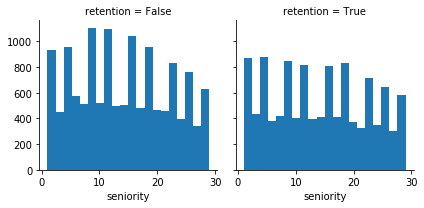

In [42]:
# 'seniority', 'salary', 'diff_years'
g = sns.FacetGrid(data, col='retention')
g.map(plt.hist, 'seniority', bins=20)

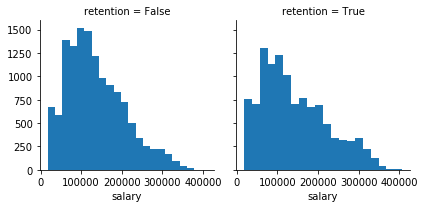

In [43]:
g = sns.FacetGrid(data, col='retention')
g.map(plt.hist, 'salary', bins=20)

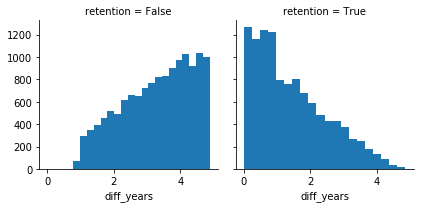

In [44]:
g = sns.FacetGrid(data, col='retention')
g.map(plt.hist, 'diff_years', bins=20)

retention by department and diff_years

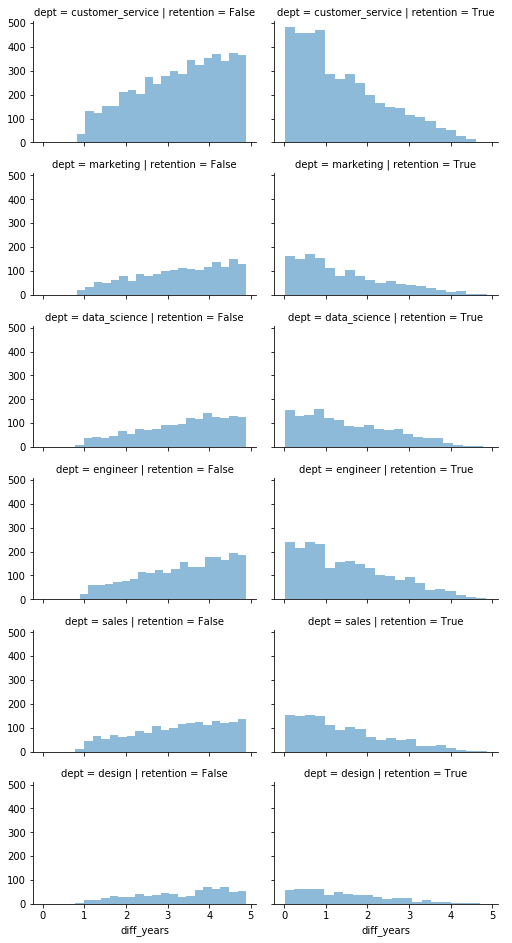

In [46]:
grid = sns.FacetGrid(data, col='retention', row='dept', height=2.2, aspect=1.6)
grid.map(plt.hist, 'diff_years', alpha=.5, bins=20)
grid.add_legend()

- retention by company_id and diff_years
- it seems that company 

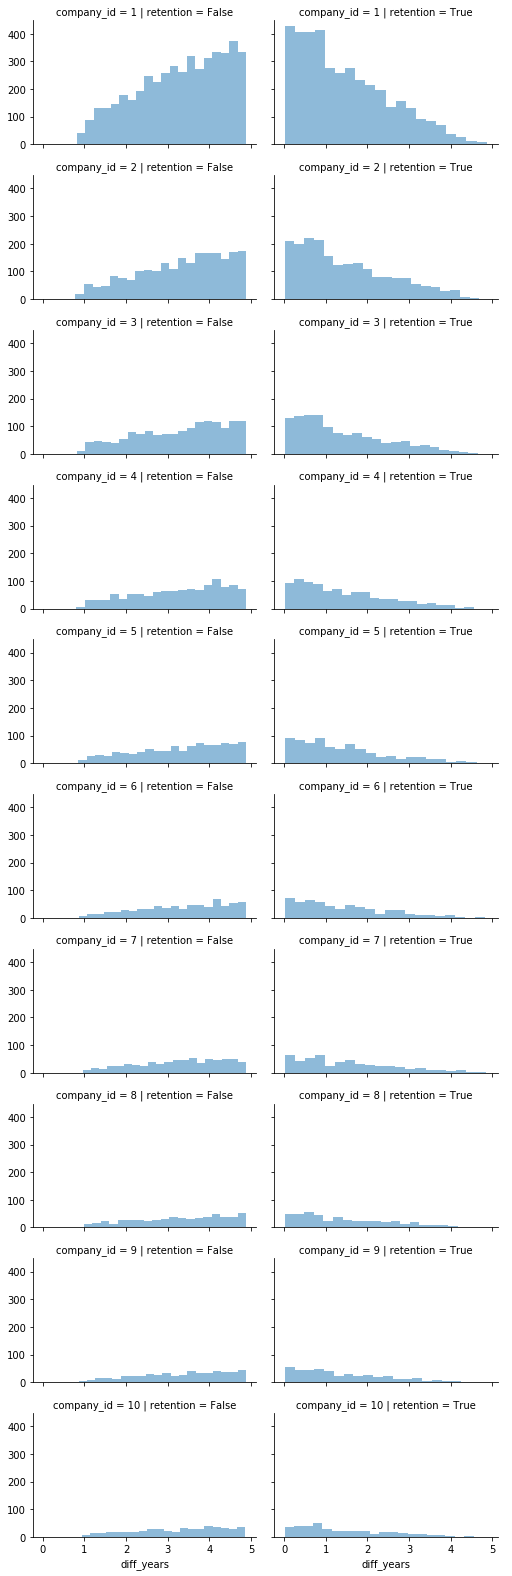

In [51]:
grid = sns.FacetGrid(data, col='retention', row='company_id', height=2.2, aspect=1.6)
grid.map(plt.hist, 'diff_years', alpha=.5, bins=20)
grid.add_legend()

- check whether there is a seasonality trend in employee's quit date

In [ ]:
# data['quit_date'] = pd.to_datetime(data['quit_date'])
# df.set_index('month', inplace=True)

### Wrangle data
#### transform categorical features

In [66]:
import pandas as pd
dept = pd.DataFrame(data['dept'])
dept = pd.concat([data, pd.get_dummies(dept, prefix=['dept'])], axis = 1)
dept.drop(['dept'], axis = 1, inplace = True)

In [69]:
data = dept
data.sample(10)

,company_id,seniority,salary,join_date,quit_date,retention,diff_years,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
employee_id,,,,,,,,,,,,,
352135.0,10,3,63000.0,2012-11-26,NaN,True,3.044553,0,0,0,1,0,0
901757.0,1,5,78000.0,2011-09-27,2014-11-14,False,4.210901,1,0,0,0,0,0
210342.0,1,22,298000.0,2014-07-14,NaN,True,1.415498,0,1,0,0,0,0
398938.0,3,24,151000.0,2015-05-11,NaN,True,0.591388,0,0,0,0,1,0
550985.0,1,7,199000.0,2013-02-19,2015-05-01,False,2.811830,0,1,0,0,0,0
724973.0,3,20,181000.0,2013-06-17,NaN,True,2.488757,0,0,0,0,1,0
235449.0,2,17,174000.0,2011-07-25,2014-12-26,False,4.386127,0,0,0,0,0,1
449462.0,2,22,192000.0,2015-05-04,NaN,True,0.610553,0,0,0,0,1,0
132009.0,1,13,120000.0,2011-06-13,2013-08-09,False,4.501119,0,0,0,0,1,0


## Model, predict and solve

In [72]:
data.columns
X, y = data[['company_id', 'seniority', 'salary','diff_years', 'dept_customer_service', 'dept_data_science',
       'dept_design', 'dept_engineer', 'dept_marketing', 'dept_sales']], data[['retention']]

In [74]:
print(X.shape)
print(y.shape)

(24660, 10)
(24660, 1)


In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape, X_test.shape

((17262, 10), (17262, 1), (7398, 10))

In [76]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [77]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train.values.ravel()) * 100, 2)
acc_log_act = round(logreg.score(X_test, y_test.values.ravel()) * 100, 2)
acc_log, acc_log_act

(76.84, 77.59)

In [78]:
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
0,company_id,0.115743
4,dept_customer_service,0.029677
1,seniority,0.008807
7,dept_engineer,0.001893
5,dept_data_science,0.000388
2,salary,0.000006
8,dept_marketing,-0.000797
6,dept_design,-0.000799
9,dept_sales,-0.001965
3,diff_years,-0.698948


In [79]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train.values.ravel())
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train.values.ravel()) * 100, 2)
acc_decision_tree_act = round(decision_tree.score(X_test, y_test.values.ravel()) * 100, 2)
acc_decision_tree,acc_decision_tree_act

(99.98, 72.11)

In [80]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, y_train.values.ravel())
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train.values.ravel()) * 100, 2)
acc_svc_act = round(svc.score(X_test, y_test.values.ravel()) * 100, 2)
acc_svc,acc_svc_act

(88.76, 72.02)

In [81]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train.values.ravel()) * 100, 2)
acc_gaussian_act = round(gaussian.score(X_test, y_test.values.ravel()) * 100, 2)
acc_gaussian, acc_gaussian_act

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(77.49, 77.89)

In [82]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train.values.ravel()) * 100, 2)
acc_perceptron_act = round(perceptron.score(X_test, y_test.values.ravel()) * 100, 2)
acc_perceptron, acc_perceptron_act

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(54.46, 55.19)

In [83]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train.values.ravel())
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train.values.ravel()) * 100, 2)
acc_linear_svc_act = round(linear_svc.score(X_test, y_test.values.ravel()) * 100, 2)
acc_linear_svc, acc_linear_svc_act

(54.46, 55.19)

In [84]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, y_train.values.ravel())
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train.values.ravel()) * 100, 2)
acc_sgd_act = round(sgd.score(X_test, y_test.values.ravel()) * 100, 2)
acc_sgd, acc_sgd_act

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


(54.46, 55.19)

In [86]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train.values.ravel())
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, y_train.values.ravel()) * 100, 2)
acc_random_forest_act = round(random_forest.score(X_test, y_test.values.ravel()) * 100, 2)
acc_random_forest, acc_random_forest_act

(99.98, 77.85)

In [87]:
#KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train.values.ravel())
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train.values.ravel()) * 100, 2)
acc_knn_act = round(knn.score(X_test, y_test.values.ravel()) * 100, 2)
acc_knn, acc_knn_act


(85.05, 69.57)

## Model evaluation
- Naive Bayes performs the best

In [88]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Train Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree],
    'Test Score': [acc_svc_act, acc_knn_act, acc_log_act, 
              acc_random_forest_act, acc_gaussian_act, acc_perceptron_act, 
              acc_sgd_act, acc_linear_svc_act, acc_decision_tree_act]})
models.sort_values(by='Test Score', ascending=False)

,Model,Test Score,Train Score
4,Naive Bayes,77.89,77.49
3,Random Forest,77.85,99.98
2,Logistic Regression,77.59,76.84
8,Decision Tree,72.11,99.98
0,Support Vector Machines,72.02,88.76
1,KNN,69.57,85.05
5,Perceptron,55.19,54.46
6,Stochastic Gradient Decent,55.19,54.46
7,Linear SVC,55.19,54.46


## Conclusion